## Methodology for IDS

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html.

Due to the large size of this dataset, sampled subsets of CICIDS2017 are used in this project. These subsets are located in the "data" folder.
If you wish to apply this code to other datasets (e.g., the CAN-intrusion dataset), simply update the dataset path and follow the same steps. The models implemented in this code are generic and can be applied to any intrusion detection or network traffic dataset.

In [ ]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')


In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [ ]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [ ]:
df.Label.value_counts()

0    2273097
3     380699
5     158930
2      13835
6       2180
1       1966
4         36
Name: Label, dtype: int64

In [ ]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [ ]:
X = df_major.drop(['Label'],axis=1)
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [ ]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [ ]:
df_major['klabel'].value_counts()

318    22146
2      20340
258    20225
308    18461
432    18154
       ...  
366       70
92        21
596       14
756       10
295        3
Name: klabel, Length: 997, dtype: int64

In [ ]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [ ]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
1,-0.439344,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,498,0
2,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,499,0
3,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,787,0
4,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,-0.438390,-0.007151,-0.008416,-0.043758,-0.007075,-0.250424,0.153902,-0.162296,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,813,0
2830739,-0.439337,-0.009819,-0.008416,-0.046560,-0.006982,-0.230903,0.385923,-0.087065,-0.245069,-0.354429,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,916,0
2830740,-0.439344,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,267,0
2830741,-0.408187,-0.004484,-0.008416,-0.035753,-0.007029,-0.244846,0.220194,-0.140802,-0.245069,-0.381659,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,634,0


In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [ ]:
result['Label'].value_counts()

0    18185
3     3029
5     1280
2      118
Name: Label, dtype: int64

In [ ]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
6980,-0.437857,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1506627,-0.438252,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1377524,-0.438860,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2056871,-0.435684,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2005567,-0.437738,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031173,-0.438439,-0.011153,-0.009418,-0.050963,-0.007110,-0.233691,0.352777,-0.097812,-0.245069,-0.410431,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
1608048,-0.438422,-0.009819,-0.008416,-0.047160,-0.007083,-0.235086,0.336204,-0.103186,-0.245069,-0.413000,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
817023,-0.437935,-0.011153,-0.009418,-0.050863,-0.007108,-0.232297,0.369350,-0.092438,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
559006,-0.437946,-0.011153,-0.009418,-0.050763,-0.007111,-0.230903,0.385923,-0.087065,-0.245069,-0.411459,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0


In [ ]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [ ]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### Preprocessing (normalization and padding values)

In [ ]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

### split train set and test set

In [ ]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

### Feature selection by information gain

In [ ]:
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [ ]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [ ]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [ ]:
X_fs = df[fs].values

In [ ]:
X_fs.shape

(26800, 44)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [ ]:
X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
X_fss.shape

(26800, 20)

### Re-split train & test sets after feature selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(21440, 20)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers 0,1,2,...
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Check the distribution again
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
2       77
4       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
4     1000
2     1000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.991044776119403
Precision of XGBoost: 0.9911135138558134
Recall of XGBoost: 0.991044776119403
F1-score of XGBoost: 0.9910279997963668
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.96      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.99      0.95      0.97      5360
weighted avg       0.99      0.99      0.99      5360



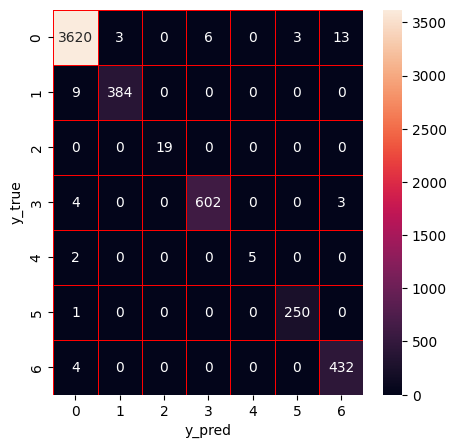

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.9966417910447761]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.35402161117683884, 'max_depth': 95.0, 'n_estimators': 40.0}


Accuracy of XGBoost: 0.996455223880597
Precision of XGBoost: 0.9964371483587836
Recall of XGBoost: 0.996455223880597
F1-score of XGBoost: 0.996436188054079
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      1.00       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       1.00      1.00      1.00       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



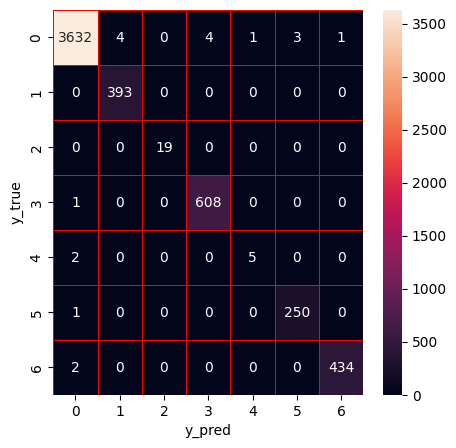

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.994776119402985
Precision of RF: 0.9947952180194924
Recall of RF: 0.994776119402985
F1-score of RF: 0.9947500440670328
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



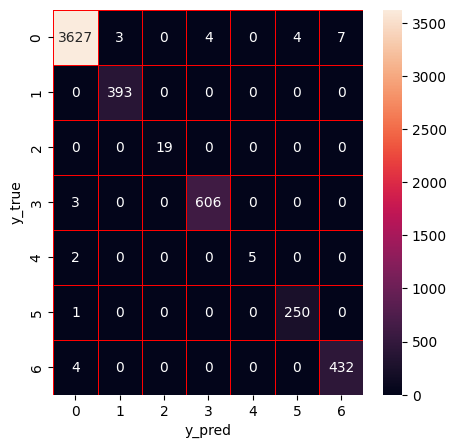

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [04:00<00:00, 12.02s/trial, best loss: -0.994776119402985] 
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 31.0, 'max_features': 19.0, 'min_samples_leaf': 2.0, 'min_samples_split': 9.0, 'n_estimators': 193.0}


Accuracy of RF: 0.9949626865671641
Precision of RF: 0.9949846805746602
Recall of RF: 0.9949626865671641
F1-score of RF: 0.9949371088112756
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



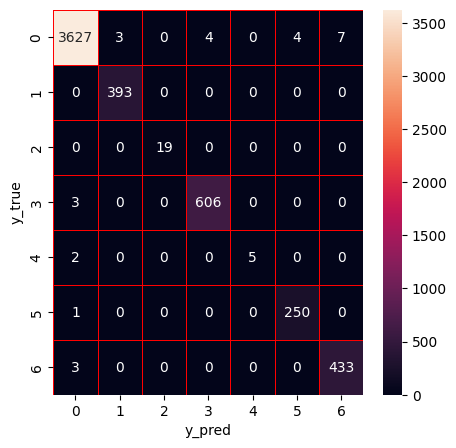

In [ ]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9932835820895523
Precision of DT: 0.9934785322581339
Recall of DT: 0.9932835820895523
F1-score of DT: 0.9933597518977868
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       0.56      0.71      0.62         7
           5       0.98      1.00      0.99       251
           6       0.97      0.98      0.98       436

    accuracy                           0.99      5360
   macro avg       0.93      0.96      0.94      5360
weighted avg       0.99      0.99      0.99      5360



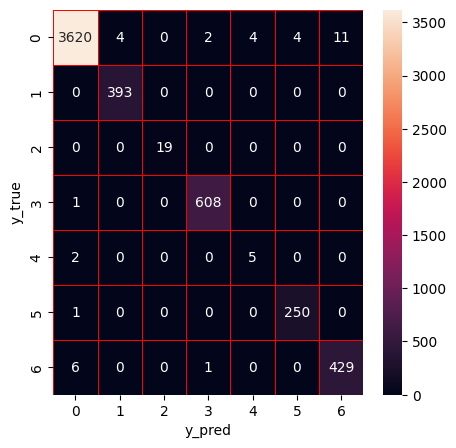

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:08<00:00,  5.93trial/s, best loss: -0.9942164179104478]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 49.0, 'max_features': 19.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0}


Accuracy of DT: 0.9936567164179104
Precision of DT: 0.9938357366612369
Recall of DT: 0.9936567164179104
F1-score of DT: 0.9937256457237901
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       0.95      1.00      0.97        19
           3       1.00      1.00      1.00       609
           4       0.56      0.71      0.62         7
           5       0.98      1.00      0.99       251
           6       0.99      0.98      0.98       436

    accuracy                           0.99      5360
   macro avg       0.92      0.95      0.94      5360
weighted avg       0.99      0.99      0.99      5360



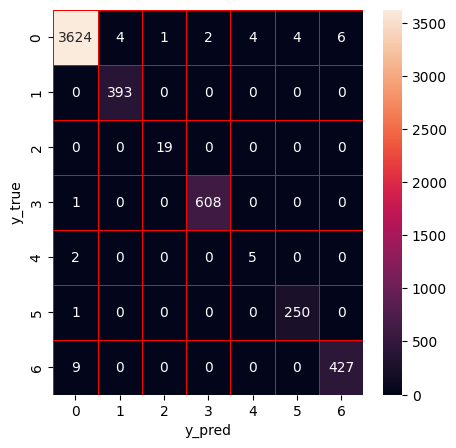

In [ ]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9949626865671641
Precision of ET: 0.9949726101001388
Recall of ET: 0.9949626865671641
F1-score of ET: 0.994933640303752
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



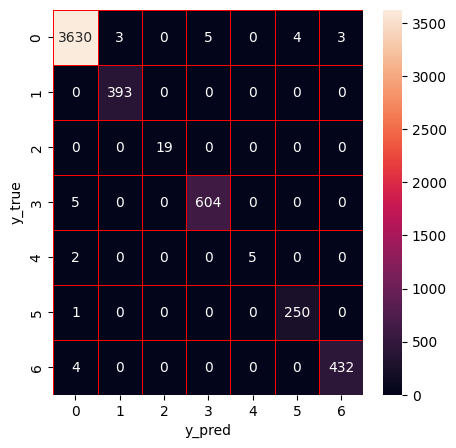

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [01:24<00:00,  4.22s/trial, best loss: -0.9955223880597015]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 35.0, 'max_features': 20.0, 'min_samples_leaf': 1.0, 'min_samples_split': 8.0, 'n_estimators': 64.0}


Accuracy of ET: 0.9957089552238806
Precision of ET: 0.9957225563328196
Recall of ET: 0.9957089552238806
F1-score of ET: 0.995680540721405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



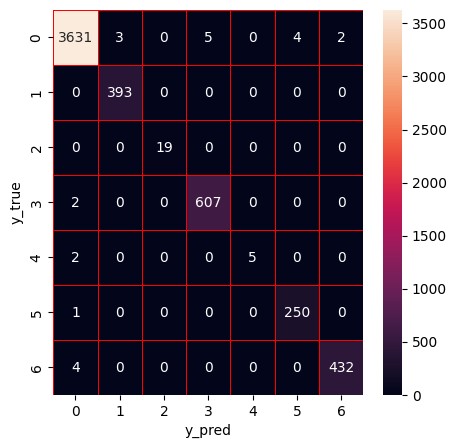

In [ ]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train)
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,0,0,0,0
4,3,3,3,3


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
dt_train.shape

(23334, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9955223880597015
Precision of Stacking: 0.9955044325882573
Recall of Stacking: 0.9955223880597015
F1-score of Stacking: 0.9955031695093179
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       0.83      0.71      0.77         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



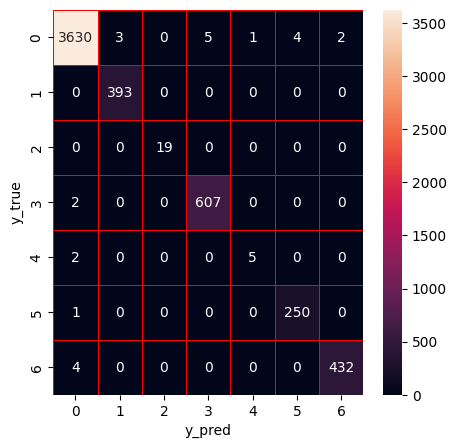

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:09<00:00,  2.04trial/s, best loss: -0.9955223880597015]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.5727516932698997, 'max_depth': 16.0, 'n_estimators': 50.0}


Accuracy of XGBoost: 0.9955223880597015
Precision of XGBoost: 0.9955044325882573
Recall of XGBoost: 0.9955223880597015
F1-score of XGBoost: 0.9955031695093179
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       0.83      0.71      0.77         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



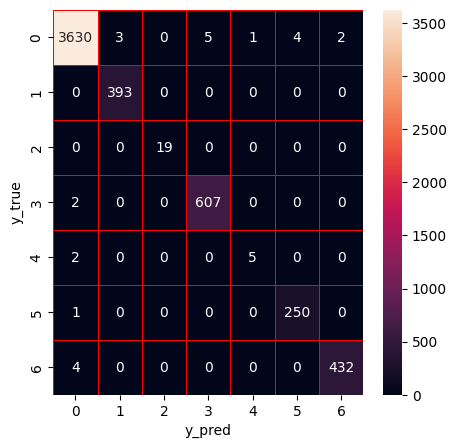

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [ ]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [ ]:
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

In [ ]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [ ]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [ ]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [ ]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [ ]:
df1.Label.value_counts()

Label
0    18225
1     7320
Name: count, dtype: int64

In [ ]:
df2.Label.value_counts()

Label
1    1255
Name: count, dtype: int64

In [ ]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [ ]:
df2.Label.value_counts()

Label
1    1255
0    1255
Name: count, dtype: int64

In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19480
1     8575
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [ ]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [ ]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [ ]:
X_fs = df[fs].values

In [ ]:
X_fs.shape

(28055, 50)

In [ ]:
X_fs

array([[-0.34612159, -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       [-0.3443274 , -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       [-0.3443274 , -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.05349902],
       ...,
       [-0.36859622, -0.35362781, -0.42933282, ..., -0.11333586,
        -0.13353417, -0.04188076],
       [-0.36859622, -0.51326791, -0.44364535, ..., -0.11333586,
        -0.13353417, -0.04188076],
       [-0.36859622, -0.46387153, -0.4144148 , ..., -0.11333586,
        -0.13353417, -0.05349902]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [ ]:
X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
X_fss.shape

(28055, 20)

In [ ]:
X_fss

array([[-0.34612159, -0.53319222, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.54906516, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.55544206, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       ...,
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229753,
        -0.28029976, -0.3887417 ],
       [-0.36859622, -0.54615396, -0.34935843, ..., -0.42228533,
        -0.28025659, -0.42271216],
       [-0.36859622, -0.49250481, -0.34935843, ..., -0.42229759,
        -0.28029998, -0.42271216]])

####  kernel principal component analysis (KPCA)

In [ ]:
from sklearn.decomposition import PCA
kpca = PCA(n_components = 10)
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [ ]:
from sklearn.decomposition import PCA
kpca = PCA(n_components = 10)
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [ ]:
pd.Series(y_train).value_counts()

0    18225
1     7320
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    18225
1    18225
Name: count, dtype: int64

In [ ]:
pd.Series(y_test).value_counts()

1    1255
0    1255
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 40)

              precision    recall  f1-score   support

           0       0.45      0.81      0.58      1255
           1       0.01      0.00      0.00      1255

    accuracy                           0.40      2510
   macro avg       0.23      0.40      0.29      2510
weighted avg       0.23      0.40      0.29      2510

0.4047808764940239
[[1014  241]
 [1253    2]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6286852589641434
43 0.44183266932270915
43 0.6756972111553785
43 0.43306772908366536
32 0.4306772908366534
20 0.850199203187251
16 0.3422310756972112
5 0.43824701195219123
15 0.9247011952191235
25 0.7035856573705179
42 0.4593625498007968
8 0.7079681274900398
21 0.7195219123505976
22 0.5832669322709163
12 0.9282868525896414
14 0.7075697211155378
2 0.48406374501992033
13 0.698406374501992
50 0.4346613545816733
11 0.6992031872509961
31.79222869873047
Best score=0.9283
Best parameters: n_clusters=12


In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']),
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

37 0.4199203187250996                                 
21 0.7175298804780876                                                           
7 0.46215139442231074                                                            
41 0.6274900398406374                                                            
7 0.4545816733067729                                                             
35 0.6729083665338645                                                            
38 0.6410358565737052                                                            
8 0.46613545816733065                                                            
47 0.6354581673306773                                                            
12 0.902788844621514                                                             
16 0.9509960159362549                                                             
39 0.6752988047808764                                                              
17 0.44262948207171315                   

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 17)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1255
           1       0.90      1.00      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1120  135]
 [   3 1252]]


## **Modified Binary Grey Wolf Optimization**

In [ ]:
## Grey Wolf optimization basic logic

!pip install -q --upgrade mealpy

from mealpy.swarm_based.GWO import OriginalGWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import BinaryVar

class MySimpleProblem(Problem):
    def __init__(self):
        bounds = [BinaryVar() for _ in range(5)]
        super().__init__(fit_func=None, bounds=bounds, minmax="min")

    def obj_func(self, solution):
        return 1.0
problem = MySimpleProblem()

# Run Grey Wolf Optimizer
model = OriginalGWO(epoch=1, pop_size=5)
best_agent = model.solve(problem)

print(" Grey Wolf Optimization ran successfully!")
print("Best solution found:", best_agent.solution)
print("Best score:", best_agent.target)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
2025/08/31 07:41:18 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: OriginalGWO(epoch=1, pop_size=5)
2025/08/31 07:41:18 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.00227 seconds


 Grey Wolf Optimization ran successfully!
Best solution found: [0. 1. 1. 1. 0.]
Best score: Objectives: [1.], Fitness: 1.0


In [ ]:
# ==========================================
# IDS – Baseline RF vs MBGWO + RF (CICIDS2017)
# ==========================================
# Requirements:
# pip install mealpy scikit-learn seaborn matplotlib pandas numpy

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 0) CONFIG
# ----------------------------
CSV_PATH = "./data/CICIDS2017_sample_km.csv"    
TARGET   = "Label"
RANDOM_SEED = 42

# MBGWO hyperparams
EPOCHS   = 20
POP_SIZE = 20
ALPHA    = 0.99   # weight on accuracy vs (1 - feature_ratio)


In [ ]:
# ----------------------------
# 1) LOAD / PREP DATAFRAME
# ----------------------------
if "df" not in globals():
    if CSV_PATH is None:
        raise RuntimeError("Set CSV_PATH to your dataset path, or define `df` beforehand.")
    df = pd.read_csv(CSV_PATH)

# Keep only numeric + target, handle categorical target
from sklearn.preprocessing import LabelEncoder
df = df.copy()

# Clean inf/nan
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure target exists
if TARGET not in df.columns:
    raise ValueError(f"TARGET '{TARGET}' not found in columns: {list(df.columns)[:10]}...")

# If target not numeric, encode to ints but preserve original labels for display
y_raw = df[TARGET]
if not np.issubdtype(df[TARGET].dtype, np.number):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    class_names = le.classes_
else:
    y = df[TARGET].astype(int).values
    class_names = np.unique(y).astype(str)

X_df = df.drop(columns=[TARGET])
# Ensure all features are numeric
X_df = X_df.select_dtypes(include=[np.number])
feature_names = X_df.columns.to_list()
X = X_df.values

In [ ]:
# ----------------------------
# 2) TRAIN / TEST SPLIT + SCALING
# ----------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
# ----------------------------
# Helpers: metrics & plots
# ----------------------------
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

def eval_metrics(clf, X_tr, y_tr, X_te, y_te, model_name="Model", plot_cm=True):
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_te, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_te, y_pred, average="weighted")

    # AUC (robust for binary / multiclass)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_te)
        if len(np.unique(y_te)) > 2:
            auc_val = roc_auc_score(y_te, y_proba, multi_class="ovr", average="weighted")
        else:
            auc_val = roc_auc_score(y_te, y_proba[:, 1])
    else:
        auc_val = np.nan

    print(f"\n=== {model_name} ===")
    from sklearn.metrics import classification_report
    print(classification_report(y_te, y_pred, target_names=[str(c) for c in np.unique(y_te)]))
    print({ "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc_val })

    if plot_cm:
        cm = confusion_matrix(y_te, y_pred)
        fig, ax = plt.subplots(figsize=(5,5))
        ConfusionMatrixDisplay(cm, display_labels=np.unique(y_te)).plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"Confusion Matrix – {model_name}")
        plt.tight_layout()
        plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc_val, "y_pred": y_pred}

def plot_roc_curves(clf, X_te, y_te, title="ROC Curves"):
    if not hasattr(clf, "predict_proba"):
        return
    y_score = clf.predict_proba(X_te)
    classes = np.unique(y_te)

    plt.figure(figsize=(6,5))
    if len(classes) > 2:
        # Multiclass OvR
        from sklearn.preprocessing import label_binarize
        y_bin = label_binarize(y_te, classes=classes)
        for i, c in enumerate(classes):
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"Class {c} (AUC={roc_auc:.2f})")
    else:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_te, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.2f}")

    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


=== Random Forest (All Features) ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3896
           1       0.99      0.99      0.99      1715

    accuracy                           0.99      5611
   macro avg       0.99      0.99      0.99      5611
weighted avg       0.99      0.99      0.99      5611

{'Accuracy': 0.9937622527178755, 'Precision': 0.9937587393132624, 'Recall': 0.9937622527178755, 'F1': 0.9937586740012259, 'AUC': 0.9983824330553577}


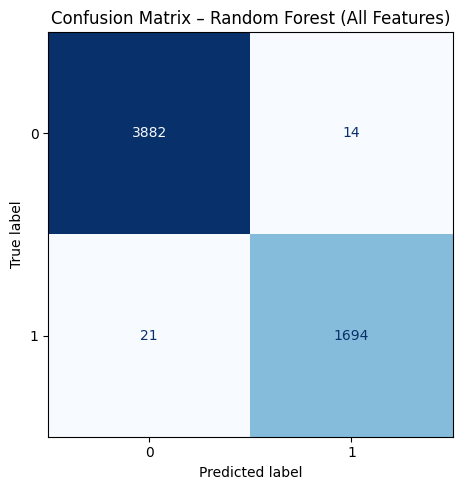

In [ ]:
# ----------------------------
# 3) BASELINE RF (ALL FEATURES)
# ----------------------------
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_base.fit(X_train, y_train)

baseline_res = eval_metrics(rf_base, X_train, y_train, X_test, y_test, 
                            model_name="Random Forest (All Features)", plot_cm=True)



In [ ]:
# ----------------------------
# 4) MBGWO FEATURE SELECTION (mealpy)
# ----------------------------
from mealpy.swarm_based.GWO import OriginalGWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import BinaryVar
from sklearn.model_selection import StratifiedKFold, cross_val_score

class FeatureSelectionProblem(Problem):
    def __init__(self, X, y, alpha=0.99, seed=RANDOM_SEED):
        self.X = X
        self.y = y
        self.alpha = alpha
        bounds = [BinaryVar() for _ in range(X.shape[1])]   # binary variables
        super().__init__(bounds=bounds, minmax="max", name="FS-IDS", seed=seed)

    def obj_func(self, sol):
        cols = [i for i, bit in enumerate(sol) if bit == 1]
        if len(cols) == 0:
            return 0.0
        Xs = self.X[:, cols]
        # lightweight RF + 3-fold CV to avoid overfitting during selection
        clf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED, n_jobs=-1)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
        acc = cross_val_score(clf, Xs, self.y, cv=cv, scoring='accuracy').mean()
        size_term = 1.0 - (len(cols) / self.X.shape[1])
        return self.alpha * acc + (1 - self.alpha) * size_term

print(f"Running MBGWO: epoch={EPOCHS}, pop_size={POP_SIZE}, alpha={ALPHA}")
problem = FeatureSelectionProblem(X_train, y_train, alpha=ALPHA, seed=RANDOM_SEED)
gwo = OriginalGWO(epoch=EPOCHS, pop_size=POP_SIZE)
best_agent = gwo.solve(problem)

mask = np.array(best_agent.solution).astype(int)
selected_features = np.where(mask == 1)[0].tolist()
print("✅ MBGWO Finished!")
print(f"Best Fitness Score: {best_agent}")
print(f"Number of Selected Features: {len(selected_features)}")
print(f"Selected Feature Indexes: {selected_features}")

2025/08/31 07:41:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: OriginalGWO(epoch=20, pop_size=20)


Running MBGWO: epoch=20, pop_size=20, alpha=0.99


2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 1, Current best: 0.9890709562257066, Global best: 0.9890709562257066, Runtime: 0.00881 seconds
2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 2, Current best: 0.9890709562257066, Global best: 0.9890709562257066, Runtime: 0.01620 seconds
2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 3, Current best: 0.9890709562257066, Global best: 0.9890709562257066, Runtime: 0.02258 seconds
2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 4, Current best: 0.9890709562257066, Global best: 0.9890709562257066, Runtime: 0.01117 seconds
2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 5, Current best: 0.9890709562257066, Global best: 0.9890709562257066, Runtime: 0.01226 seconds
2025/08/31 07:42:05 PM, INFO, mealpy.swarm_based.GWO.Origina

✅ MBGWO Finished!
Best Fitness Score: id: 5798, target: Objectives: [0.99142817], Fitness: 0.9914281675545994, solution: [1.         1.         0.         1.         1.         0.
 0.66666667 0.         0.33333333 0.33333333 0.33333333 0.66666667
 0.66666667 0.33333333 0.66666667 0.33333333 1.         0.33333333
 0.66666667 0.66666667 1.         1.         0.33333333 1.
 0.         0.66666667 0.33333333 0.33333333 1.         0.33333333
 0.33333333 0.66666667 0.66666667 0.66666667 0.66666667 0.
 0.         0.66666667 0.         0.66666667 1.         0.66666667
 0.33333333 0.         1.         0.         0.         0.33333333
 0.66666667 0.33333333 0.33333333 0.66666667 0.66666667 0.66666667
 0.         0.66666667 0.33333333 0.         0.66666667 0.66666667
 0.66666667 0.33333333 0.33333333 0.33333333 0.33333333 1.
 0.66666667 0.66666667 0.         0.33333333 0.66666667 0.
 0.66666667 0.         0.         0.         0.66666667]
Number of Selected Features: 12
Selected Feature Indexes: 


=== Random Forest + MBGWO ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3896
           1       1.00      0.99      0.99      1715

    accuracy                           0.99      5611
   macro avg       0.99      0.99      0.99      5611
weighted avg       0.99      0.99      0.99      5611

{'Accuracy': 0.994475138121547, 'Precision': 0.9944782791833937, 'Recall': 0.994475138121547, 'F1': 0.9944683120610559, 'AUC': 0.9990929622068834}


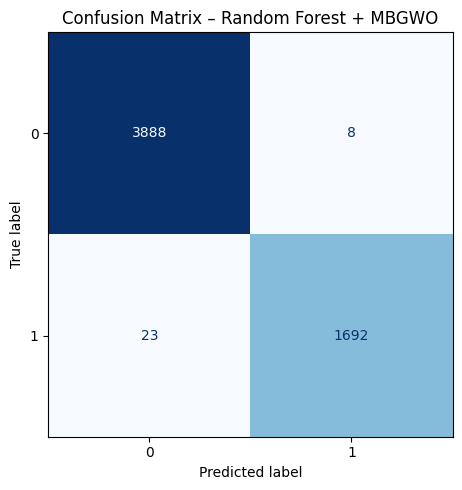

In [ ]:
# ----------------------------
# 5) RF on MBGWO-SELECTED FEATURES
# ----------------------------
if len(selected_features) == 0:
    raise RuntimeError("MBGWO selected 0 features. Consider lowering ALPHA or increasing EPOCHS/POP_SIZE.")

X_train_sel = X_train[:, selected_features]
X_test_sel  = X_test[:, selected_features]

rf_sel = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_sel.fit(X_train_sel, y_train)

mbgwo_res = eval_metrics(rf_sel, X_train_sel, y_train, X_test_sel, y_test, 
                         model_name="Random Forest + MBGWO", plot_cm=True)


In [ ]:
# ----------------------------
# 6) COMPARISON TABLE
# ----------------------------
comparison = pd.DataFrame([
    {"Model": "Random Forest (All Features)",
     "Accuracy": baseline_res["Accuracy"],
     "Precision": baseline_res["Precision"],
     "Recall": baseline_res["Recall"],
     "F1": baseline_res["F1"],
     "AUC": baseline_res["AUC"]},
    {"Model": "Random Forest + MBGWO",
     "Accuracy": mbgwo_res["Accuracy"],
     "Precision": mbgwo_res["Precision"],
     "Recall": mbgwo_res["Recall"],
     "F1": mbgwo_res["F1"],
     "AUC": mbgwo_res["AUC"]}
])
print("\n=== Comparison ===")
print(comparison)


=== Comparison ===
                          Model  Accuracy  Precision    Recall        F1  \
0  Random Forest (All Features)  0.993762   0.993759  0.993762  0.993759   
1         Random Forest + MBGWO  0.994475   0.994478  0.994475  0.994468   

        AUC  
0  0.998382  
1  0.999093  


### Logistic Regression + PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_pca, y_train)
y_pred_lr = lr.predict(X_test_pca)
y_prob_lr = lr.predict_proba(X_test_pca)[:,1]

lr_results = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average="weighted"),
    "Recall": recall_score(y_test, y_pred_lr, average="weighted"),
    "F1": f1_score(y_test, y_pred_lr, average="weighted"),
    "AUC": roc_auc_score(y_test, y_prob_lr, multi_class="ovr")
}

In [ ]:
# ----------------------------
#  COMPARISON TABLE FOR ALL MODELS
# ----------------------------
comparison = pd.DataFrame([
    {"Model": "Random Forest (All Features)",
     "Accuracy": baseline_res["Accuracy"],
     "Precision": baseline_res["Precision"],
     "Recall": baseline_res["Recall"],
     "F1": baseline_res["F1"],
     "AUC": baseline_res["AUC"]},
     {"Model": "Logistic Regression + PCA",
     "Accuracy": lr_results["Accuracy"],
     "Precision": lr_results["Precision"],
     "Recall": lr_results["Recall"],
     "F1": lr_results["F1"],
     "AUC": lr_results["AUC"]},
    {"Model": "Random Forest + MBGWO",
     "Accuracy": mbgwo_res["Accuracy"],
     "Precision": mbgwo_res["Precision"],
     "Recall": mbgwo_res["Recall"],
     "F1": mbgwo_res["F1"],
     "AUC": mbgwo_res["AUC"]}
])
print("\n=== Comparison ===")
print(comparison)


=== Comparison ===
                          Model  Accuracy  Precision    Recall        F1  \
0  Random Forest (All Features)  0.993762   0.993759  0.993762  0.993759   
1     Logistic Regression + PCA  0.826234   0.822862  0.826234  0.817692   
2         Random Forest + MBGWO  0.994475   0.994478  0.994475  0.994468   

        AUC  
0  0.998382  
1  0.848745  
2  0.999093  
